In [13]:
import numpy as np
import torch
import sys
import matplotlib.pyplot as plt

sys.path.append("../../")
sys.path.append("../")
from utils import simulate_lorenz_96, compare_graphs
import NMC as models
import importlib
import os
import glob
import pandas as pd
import scipy.sparse as sp
import anndata as ad
from src import util


In [14]:
class DataLoader:
    def __init__(self, data_path, dataset_type="Synthetic"):
        """
        Initialize DataLoader

        Args:
            data_path: Path to data directory
            dataset_type: Either "Synthetic" or "Curated"
        """
        self.data_path = os.path.join(data_path, dataset_type)
        self.dataset_type = dataset_type
        self.adatas = None
        self.kos = None
        self.true_matrix = None

    def load_data(self):
        """Load and preprocess data"""
        if self.dataset_type == "Synthetic":
            paths = glob.glob(
                os.path.join(self.data_path, "dyn-TF/dyn-TF*-1")
            ) + glob.glob(os.path.join(self.data_path, "dyn-TF_ko*/dyn-TF*-1"))
        elif self.dataset_type == "Curated":
            paths = glob.glob(os.path.join(self.data_path, f"HSC*/HSC*-1"))
        else:
            raise ValueError(f"Unknown dataset type: {self.dataset_type}")

        self.adatas = [util.load_adata(p) for p in paths]

        df = pd.read_csv(os.path.join(os.path.dirname(paths[0]), "refNetwork.csv"))

        n_genes = self.adatas[0].n_vars

        # Create empty matrix with gene names
        self.true_matrix = pd.DataFrame(
            np.zeros((n_genes, n_genes), int),
            index=self.adatas[0].var.index,
            columns=self.adatas[0].var.index,
        )

        # Fill matrix with interaction values
        for i in range(df.shape[0]):
            _i = df.iloc[i, 1]  # target gene
            _j = df.iloc[i, 0]  # source gene
            _v = {"+": 1, "-": -1}[df.iloc[i, 2]]  # interaction type
            self.true_matrix.loc[_i, _j] = _v

        # Bin timepoints
        t_bins = np.linspace(0, 1, T + 1)[:-1]
        for adata in self.adatas:
            adata.obs["t"] = np.digitize(adata.obs.t_sim, t_bins) - 1

        # Get knockouts
        self.kos = []
        for p in paths:
            try:
                self.kos.append(os.path.basename(p).split("_ko_")[1].split("-")[0])
            except:
                self.kos.append(None)

        self.gene_to_index = {
            gene: idx for idx, gene in enumerate(self.adatas[0].var.index)
        }
        self.ko_indices = []
        for ko in self.kos:
            if ko is None:
                self.ko_indices.append(None)
            else:
                self.ko_indices.append(self.gene_to_index[ko])

In [16]:
T = 5
data_loader = DataLoader("../../data/simulation", dataset_type="Synthetic")
data_loader.load_data()
adatas, kos, ko_indices, true_matrix = (
    data_loader.adatas,
    data_loader.kos,
    data_loader.ko_indices,
    data_loader.true_matrix.values,
)

[AnnData object with n_obs × n_vars = 1000 × 8
    obs: 't_sim', 't'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', AnnData object with n_obs × n_vars = 1000 × 8
    obs: 't_sim', 't'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', AnnData object with n_obs × n_vars = 1000 × 8
    obs: 't_sim', 't'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', AnnData object with n_obs × n_vars = 1000 × 8
    obs: 't_sim', 't'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', AnnData object with n_obs × n_vars = 1000 × 8
    obs: 't_sim', 't'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities', AnnData o

In [52]:
genes = adatas[0].n_vars
data = torch.tensor(adatas[0].X.astype(np.float32))
data = data.unsqueeze(1)

times = adatas[0].obs["t"]
times = times.to_numpy()
times_np = np.hstack([times[:, None]])
times = torch.from_numpy(times_np[:,:, None].astype(np.float32))

In [53]:
# Specify device.
device = "cpu"  # Select device: "cpu", "cuda", "cuda:1", etc.
device = torch.device(device)

In [54]:
importlib.reload(models)

# Function specification.
func = models.MLPODEF(dims=[genes, 100, 1], GL_reg=0.1, time_invariant=False)
func = func.to(device)


In [55]:
importlib.reload(models)

# Group Lasso training.
models.train(func, data, n_steps=1000, plot_freq=20, device=device, horizon=2)

# Adaptive Group lasso training.
# weights = func.group_weights()
# func.GL_reg *= 1 / weights
# func.reset_parameters()
# models.train(func, data, n_steps=1000, plot_freq=20, device=device)

RuntimeError: zero-dimensional tensor (at position 1) cannot be concatenated

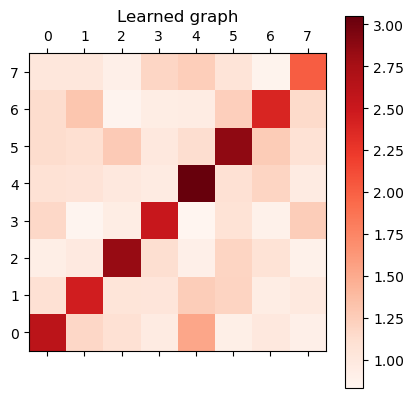

In [46]:
graph = func.causal_graph(w_threshold=0.0)
plt.matshow(graph, cmap="Reds")
plt.gca().invert_yaxis()
plt.colorbar()
plt.title("Learned graph")
plt.show()

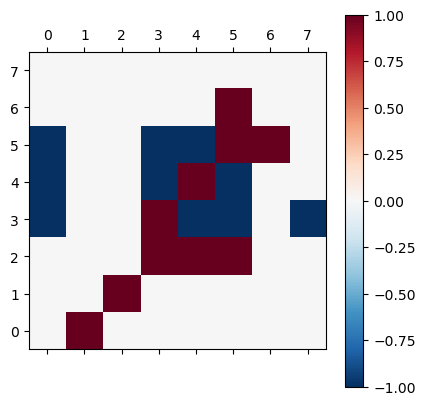

In [37]:
plt.matshow(data_loader.true_matrix, cmap="RdBu_r")
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()


In [35]:
data_loader.true_matrix

,g1,g2,g3,g4,g5,g6,g7,g8
g1,0,1,0,0,0,0,0,0
g2,0,0,1,0,0,0,0,0
g3,0,0,0,1,1,1,0,0
g4,-1,0,0,1,-1,-1,0,-1
g5,-1,0,0,-1,1,-1,0,0
g6,-1,0,0,-1,-1,1,1,0
g7,0,0,0,0,0,1,0,0
g8,0,0,0,0,0,0,0,0
